In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

In [ ]:
seed_val = 5218

np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
size_input = train_images[0].shape[0] * train_images[0].shape[1]
size_hidden = 128
size_hidden_2 = 128
size_output = 10
learning_rate_hp = 1e-4
number_of_train_examples = train_images.shape[0] - 10000
number_of_validation_examples = 10000
number_of_test_examples = test_images.shape[0]
train_batch = 60
test_batch = 10
lamda = 0.7
NUM_EPOCHS = 3000

print("Input layer size:", size_input)
print("Hidden layer 1 size:", size_hidden)
print("Hidden layer 2 size:", size_hidden_2)
print("Ouput layer size:", size_output)
print("-------------------------------------")
print("Size of the training set:", number_of_train_examples)
print("Size of the validation set:", number_of_validation_examples)
print("Size of the test set:", number_of_test_examples)

Input layer size: 784
Hidden layer 1 size: 128
Hidden layer 2 size: 128
Ouput layer size: 10
-------------------------------------
Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


In [ ]:
X_train = train_images.reshape(train_images.shape[0], -1)[0:50000]
X_val = train_images.reshape(train_images.shape[0], -1)[50000:60000]
X_test = test_images.reshape(test_images.shape[0], -1)

y_train = np.reshape(train_labels[0:50000], (number_of_train_examples, 1))
y_val = np.reshape(train_labels[50000:60000], (number_of_validation_examples, 1))
y_test = np.reshape(test_labels, (number_of_test_examples, 1))

In [ ]:
 # Normalizing the images
x_train = X_train / 255.0
x_val = X_val / 255.0
x_test = X_test / 255.0

In [ ]:
# One hot encoding the labels
def one_hot_encode(vec):
  n = len(vec)
  out = np.zeros((n, 10))
  for i in range(n):
    out[i, vec[i]] = 1
  return out

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [ ]:
def compute_accuracy(mlp, X, y):
  '''
  This function does a forward pass of x, then checks if the indices
  of the maximum value in the output equals the indices in the label 
  y. Then it sums over each prediction and calculates the accuracy.
  '''
  predictions = []
  # for x, y in zip(X, y):
  #   x = tf.reshape(x, (1, size_input))
  #   output = mlp.forward(x)
  #   pred = np.argmax(output)
  #   predictions.append(pred == np.argmax(y))

  output = mlp.forward(X)
  pred = np.argmax(output, axis=1)
  predictions.append(pred == np.argmax(y, axis=1))

  return np.mean(predictions)

In [ ]:
def sigmoid(x, derivative = False):
    if derivative:
        return np.exp(-x) / ((np.exp(-x) + 1) ** 2)
    else:
        return 1 / (1 + np.exp(-x))

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_hidden_2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden, size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden]))
    # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden_2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))
    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #l2_rg = (lamda / (2.0 * number_of_train_examples)) * (np.sum(np.square(self.variables[0])) + np.sum(np.square(self.variables[1])) + np.sum(np.square(self.variables[2])))
    #l1_rg = (lamda / number_of_train_examples) * (np.sum(self.variables[0]) + np.sum(self.variables[1]) + np.sum(self.variables[2]))
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #print(self.variables)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_hp)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer 1
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.sigmoid(what)
    # Compute values in hidden layer 2
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.sigmoid(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
from tensorflow.python.ops.nn_impl import compute_average_loss
# Initialize model using GPU
mlp = MLP(size_input, size_hidden, size_hidden_2, size_output, device='gpu')
error = []
accuracy = []
accuracy_val = []
time_start = time.time()
for epoch in range(NUM_EPOCHS + 1):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(train_batch)

  preds = mlp.forward(X_train)
  loss_total = loss_total + mlp.loss(preds, y_train)
  lt = lt + mlp.loss(preds, y_train)
  gd = mlp.backward(X_train, y_train)
  '''
  This code is for batch gradient descent
  '''
  '''
  mlp.vanillasgd(gd)
  for inputs, outputs in train_ds: 
    preds = mlp.forward(inputs)
    #print(inputs.shape, " ", outputs.shape, " ", preds.shape)
    loss_total = loss_total + mlp.loss(preds, outputs)
    lt = lt + mlp.loss(preds, outputs)
    gd = mlp.backward(inputs, outputs)
    #mlp.vanillasgd(gd)
  '''
  curr_error = np.sum(loss_total) / X_train.shape[0]
  error.append(curr_error)
  curr_accuracy = compute_accuracy(mlp, X_train, y_train) * 100
  curr_accuracy_val = compute_accuracy(mlp, X_val, y_val) * 100
  accuracy_val.append(curr_accuracy)
  accuracy.append(curr_accuracy)
  if(epoch % 100 == 0):
    print('Epoch:{} \nAverage Error: {} \nAccuracy on training set:= {:.2f}% \nAccuracy on validation set:= {:.2f}%\n\n'.format(epoch, curr_error, curr_accuracy, curr_accuracy_val))
time_taken = time.time() - time_start

print('\n\nAccuracy on Test set:', compute_accuracy(mlp, X_test, y_test) * 100)

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Epoch:0 
Average Error: 2.42351 
Accuracy on training set:= 10.14% 
Accuracy on validation set:= 9.90%


Epoch:100 
Average Error: 1.89299078125 
Accuracy on training set:= 65.13% 
Accuracy on validation set:= 66.52%


Epoch:200 
Average Error: 1.4741553125 
Accuracy on training set:= 76.57% 
Accuracy on validation set:= 78.16%


Epoch:300 
Average Error: 1.138865234375 
Accuracy on training set:= 81.93% 
Accuracy on validation set:= 83.03%


Epoch:400 
Average Error: 0.898561484375 
Accuracy on training set:= 84.58% 
Accuracy on validation set:= 85.61%


Epoch:500 
Average Error: 0.730832734375 
Accuracy on training set:= 85.91% 
Accuracy on validation set:= 86.89%


Epoch:600 
Average Error: 0.611648046875 
Accuracy on training set:= 86.77% 
Accuracy on validation set:= 87.73%


Epoch:700 
Average Error: 0.5259401953125 
Accuracy on training set:= 87.45% 
Accuracy on validation set:= 88.15%


Epoch:800 
Average Error: 0.4631641796875 
Accuracy on training set:= 88.04% 
Accuracy on va

Predicted output:=  6
Actual ouput:=  4


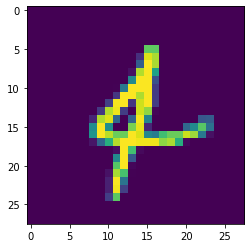

In [ ]:
# Testing the model 
test_index = 300
test_data = tf.reshape(X_test[test_index], (1, size_input))
output = mlp.forward(test_data)
pred = np.argmax(output, axis=1)
print("Predicted output:= ", int(pred))
print("Actual ouput:= ", test_labels[test_index])
plt.imshow(test_images[test_index])

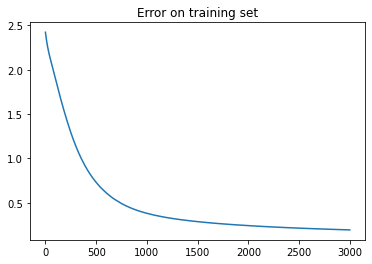

In [ ]:
# Plotting Crossentropy error
plt.title("Error on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], error)

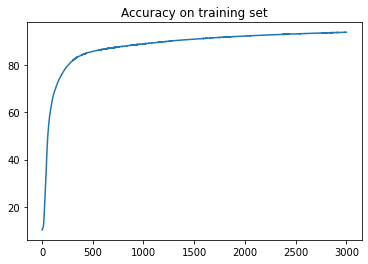

In [ ]:
# Plotting accuracy
plt.title("Accuracy on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy)

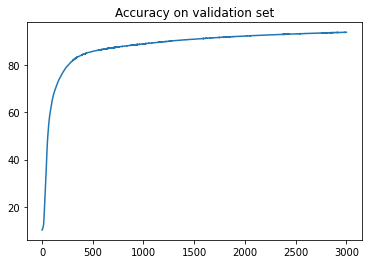

In [ ]:
# Plotting validation accuracy
plt.title("Accuracy on validation set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy_val)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_hidden_2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden, size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden]))
    # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden_2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))
    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #l2_rg = (lamda / (2.0 * number_of_train_examples)) * (np.sum(np.square(self.variables[0])) + np.sum(np.square(self.variables[1])) + np.sum(np.square(self.variables[2])))
    #l1_rg = (lamda / number_of_train_examples) * (np.sum(self.variables[0]) + np.sum(self.variables[1]) + np.sum(self.variables[2]))
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #print(self.variables)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_hp)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer 1
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.sigmoid(what)
    # Compute values in hidden layer 2
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.sigmoid(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
from tensorflow.python.ops.nn_impl import compute_average_loss
# Initialize model using GPU
mlp = MLP(size_input, size_hidden, size_hidden_2, size_output, device='gpu')
error = []
accuracy = []
accuracy_val = []
time_start = time.time()
for epoch in range(NUM_EPOCHS + 1):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(train_batch)

  preds = mlp.forward(X_train)
  loss_total = loss_total + mlp.loss(preds, y_train)
  lt = lt + mlp.loss(preds, y_train)
  gd = mlp.backward(X_train, y_train)
  '''
  This code is for batch gradient descent
  '''
  '''
  mlp.vanillasgd(gd)
  for inputs, outputs in train_ds: 
    preds = mlp.forward(inputs)
    #print(inputs.shape, " ", outputs.shape, " ", preds.shape)
    loss_total = loss_total + mlp.loss(preds, outputs)
    lt = lt + mlp.loss(preds, outputs)
    gd = mlp.backward(inputs, outputs)
    #mlp.vanillasgd(gd)
  '''
  curr_error = np.sum(loss_total) / X_train.shape[0]
  error.append(curr_error)
  curr_accuracy = compute_accuracy(mlp, X_train, y_train) * 100
  curr_accuracy_val = compute_accuracy(mlp, X_val, y_val) * 100
  accuracy_val.append(curr_accuracy)
  accuracy.append(curr_accuracy)
  if(epoch % 100 == 0):
    print('Epoch:{} \nAverage Error: {} \nAccuracy on training set:= {:.2f}% \nAccuracy on validation set:= {:.2f}%\n\n'.format(epoch, curr_error, curr_accuracy, curr_accuracy_val))
time_taken = time.time() - time_start

print('\n\nAccuracy on Test set:', compute_accuracy(mlp, X_test, y_test) * 100)

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Epoch:0 
Average Error: 2.38283984375 
Accuracy on training set:= 11.92% 
Accuracy on validation set:= 12.44%


Epoch:100 
Average Error: 1.105422109375 
Accuracy on training set:= 82.65% 
Accuracy on validation set:= 84.55%


Epoch:200 
Average Error: 0.561581171875 
Accuracy on training set:= 88.02% 
Accuracy on validation set:= 89.05%


Epoch:300 
Average Error: 0.373303046875 
Accuracy on training set:= 89.72% 
Accuracy on validation set:= 90.13%


Epoch:400 
Average Error: 0.3030035546875 
Accuracy on training set:= 90.92% 
Accuracy on validation set:= 90.91%


Epoch:500 
Average Error: 0.27041314453125 
Accuracy on training set:= 91.60% 
Accuracy on validation set:= 91.50%


Epoch:600 
Average Error: 0.250508203125 
Accuracy on training set:= 92.18% 
Accuracy on validation set:= 91.84%


Epoch:700 
Average Error: 0.23602607421875 
Accuracy on training set:= 92.66% 
Accuracy on validation set:= 92.06%


Epoch:800 
Average Error: 0.22491 
Accuracy on training set:= 93.07% 
Accuracy

Predicted output:=  4
Actual ouput:=  4


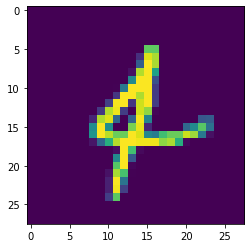

In [ ]:
# Testing the model 
test_index = 300
test_data = tf.reshape(X_test[test_index], (1, size_input))
output = mlp.forward(test_data)
pred = np.argmax(output, axis=1)
print("Predicted output:= ", int(pred))
print("Actual ouput:= ", test_labels[test_index])
plt.imshow(test_images[test_index])

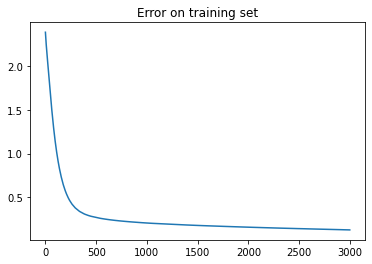

In [ ]:
# Plotting Crossentropy error
plt.title("Error on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], error)

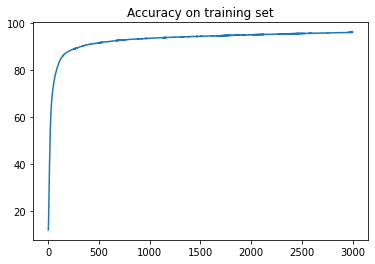

In [ ]:
# Plotting accuracy
plt.title("Accuracy on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy)

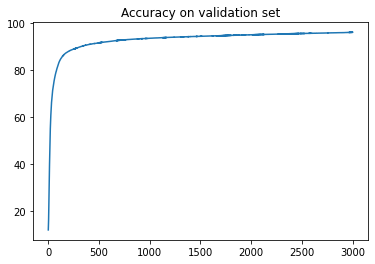

In [ ]:
# Plotting validation accuracy
plt.title("Accuracy on validation set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy_val)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_hidden_2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden, size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden]))
    # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden_2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))
    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #l2_rg = (lamda / (2.0 * number_of_train_examples)) * (np.sum(np.square(self.variables[0])) + np.sum(np.square(self.variables[1])) + np.sum(np.square(self.variables[2])))
    #l1_rg = (lamda / number_of_train_examples) * (np.sum(self.variables[0]) + np.sum(self.variables[1]) + np.sum(self.variables[2]))
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #print(self.variables)
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_hp)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer 1
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.sigmoid(what)
    # Compute values in hidden layer 2
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.sigmoid(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
from tensorflow.python.ops.nn_impl import compute_average_loss
# Initialize model using GPU
mlp = MLP(size_input, size_hidden, size_hidden_2, size_output, device='gpu')
error = []
accuracy = []
accuracy_val = []
time_start = time.time()
for epoch in range(NUM_EPOCHS + 1):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(train_batch)

  preds = mlp.forward(X_train)
  loss_total = loss_total + mlp.loss(preds, y_train)
  lt = lt + mlp.loss(preds, y_train)
  gd = mlp.backward(X_train, y_train)
  '''
  This code is for batch gradient descent
  '''
  '''
  mlp.vanillasgd(gd)
  for inputs, outputs in train_ds: 
    preds = mlp.forward(inputs)
    #print(inputs.shape, " ", outputs.shape, " ", preds.shape)
    loss_total = loss_total + mlp.loss(preds, outputs)
    lt = lt + mlp.loss(preds, outputs)
    gd = mlp.backward(inputs, outputs)
    #mlp.vanillasgd(gd)
  '''
  curr_error = np.sum(loss_total) / X_train.shape[0]
  error.append(curr_error)
  curr_accuracy = compute_accuracy(mlp, X_train, y_train) * 100
  curr_accuracy_val = compute_accuracy(mlp, X_val, y_val) * 100
  accuracy_val.append(curr_accuracy)
  accuracy.append(curr_accuracy)
  if(epoch % 100 == 0):
    print('Epoch:{} \nAverage Error: {} \nAccuracy on training set:= {:.2f}% \nAccuracy on validation set:= {:.2f}%\n\n'.format(epoch, curr_error, curr_accuracy, curr_accuracy_val))
time_taken = time.time() - time_start

print('\n\nAccuracy on Test set:', compute_accuracy(mlp, X_test, y_test) * 100)

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Epoch:0 
Average Error: 2.34765 
Accuracy on training set:= 9.72% 
Accuracy on validation set:= 9.83%


Epoch:100 
Average Error: 0.7705184375 
Accuracy on training set:= 68.20% 
Accuracy on validation set:= 69.67%


Epoch:200 
Average Error: 0.84165890625 
Accuracy on training set:= 72.85% 
Accuracy on validation set:= 74.77%


Epoch:300 
Average Error: 1.40567046875 
Accuracy on training set:= 58.80% 
Accuracy on validation set:= 60.26%


Epoch:400 
Average Error: 0.24594103515625 
Accuracy on training set:= 89.39% 
Accuracy on validation set:= 89.74%


Epoch:500 
Average Error: 0.159892724609375 
Accuracy on training set:= 95.61% 
Accuracy on validation set:= 94.88%


Epoch:600 
Average Error: 0.11837587890625 
Accuracy on training set:= 96.70% 
Accuracy on validation set:= 95.46%


Epoch:700 
Average Error: 0.10834263671875 
Accuracy on training set:= 96.99% 
Accuracy on validation set:= 95.63%


Epoch:800 
Average Error: 0.08643205078125 
Accuracy on training set:= 97.60% 
Accurac

Predicted output:=  4
Actual ouput:=  4


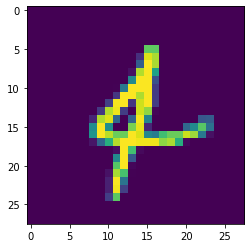

In [ ]:
# Testing the model 
test_index = 300
test_data = tf.reshape(X_test[test_index], (1, size_input))
output = mlp.forward(test_data)
pred = np.argmax(output, axis=1)
print("Predicted output:= ", int(pred))
print("Actual ouput:= ", test_labels[test_index])
plt.imshow(test_images[test_index])

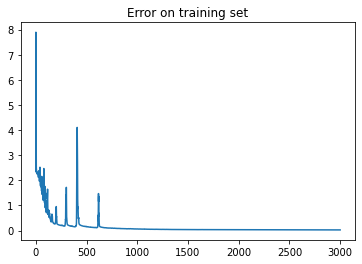

In [ ]:
# Plotting Crossentropy error
plt.title("Error on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], error)

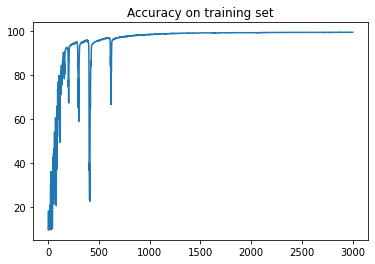

In [ ]:
# Plotting accuracy
plt.title("Accuracy on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy)

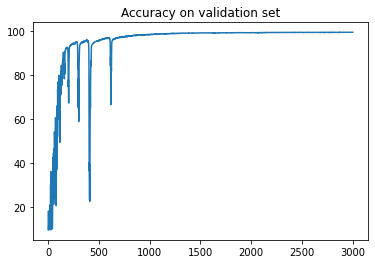

In [ ]:
# Plotting validation accuracy
plt.title("Accuracy on validation set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy_val)

In [ ]:
def compute_accuracy_custom(mlp, X, y):
  '''
  This function does a forward pass of x, then checks if the indices
  of the maximum value in the output equals the indices in the label 
  y. Then it sums over each prediction and calculates the accuracy.
  '''
  predictions = []
  # for x, y in zip(X, y):
  #   x = tf.reshape(x, (1, size_input))
  #   output = mlp.forward(x)
  #   pred = np.argmax(output)
  #   predictions.append(pred == np.argmax(y))

  output = mlp.forward(X)
  pred = np.argmax(output, axis=1)
  predictions.append(pred == np.argmax(y, axis=1))

  return np.mean(predictions)

In [ ]:
class CustomOpti:
    def __init__(self, var, alpha=1e-4, beta1=0.9, beta2=0.999, beta3=0.999987, epsilon=1e-8, epsilon2=1e-6):
        self.m_d = [tf.zeros_like(i) for i in var]
        self.u_d = [tf.zeros_like(i) for i in var]
        self.v_d = [tf.zeros_like(i) for i in var]
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.epsilon = epsilon
        self.epsilon2 = epsilon2
        self.t = 0
    def update(self, grads, variables):
        self.t += 1
        self.m_d = [i * self.beta1 + (1 - self.beta1) * j for i, j in zip(self.m_d, grads) ]
        self.u_d = [i * self.beta2 + (1 - self.beta2) * (j ** 2) for i, j in zip(self.u_d, grads) ]
        self.v_d = [i * self.beta3 + (1 - self.beta3) * (j ** 3) for i, j in zip(self.v_d, grads) ]

        m_cap = [i / (1 - (self.beta1 ** self.t)) for i in self.m_d]
        u_cap = [i / (1 - (self.beta2 ** self.t)) for i in self.u_d]
        v_cap = [i / (1 - (self.beta3 ** self.t)) for i in self.v_d]
        v_cap_sign=[tf.math.sign(i) for i in v_cap]
        v_cap_abs=[tf.abs(i) for i in v_cap]

        temp = [self.alpha * i / (self.epsilon + tf.sqrt(j) + (lamda * tf.pow(k, 1.0 / 3.0) * self.epsilon)) for i, j, k, l in zip(m_cap, u_cap, v_cap_abs,v_cap_sign)]
        update_val = [i - j for i, j in zip(variables, temp)]

        return update_val

In [ ]:
from tensorflow.python.ops.nn_impl import compute_average_loss

# Define class to build mlp model
class CustomMLP(object):
  def __init__(self, size_input, size_hidden, size_hidden_2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden, size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden]))
     # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden_2], stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))
    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

    self.optimizer = CustomOpti(var = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3])
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #l2_rg = (lamda / (2.0 * number_of_train_examples)) * (np.sum(np.square(self.variables[0])) + np.sum(np.square(self.variables[1])) + np.sum(np.square(self.variables[2])))
    #l1_rg = (lamda / number_of_train_examples) * (np.sum(self.variables[0]) + np.sum(self.variables[1]) + np.sum(self.variables[2]))
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train, epoch):
    """
    backward pass
    """
    '''
    predicted, cache = self.forward(X_train)
    current_loss = self.loss(predicted, y_train)

    Z1 = cache['Z1']
    Z2 = cache['Z2']

    dZ3 = predicted - y_train
    dZ3 = tf.cast(dZ3, dtype=tf.float32)
    dW3 = (1 / X_train.shape[0]) * tf.tensordot(tf.transpose(Z2), dZ3, 1)
    db3 = (1 / X_train.shape[0]) * np.sum(dZ3, axis=0, keepdims=True)
    assert dW3.shape == self.W3.shape

    dZ2 = tf.tensordot(dZ3, tf.transpose(self.W3), 1) * sigmoid(Z2, True)
    dW2 = (1 / X_train.shape[0]) * tf.tensordot(tf.transpose(Z1), dZ2, 1)
    db2 = (1 / X_train.shape[0]) * np.sum(dZ2, axis=0, keepdims=True)
    assert dW2.shape == self.W2.shape

    dZ1 = tf.tensordot(dZ2, tf.transpose(self.W2), 1) * sigmoid(Z1, True)
    X_train = tf.cast(X_train, dtype=tf.float32)
    dW1 = (1 / X_train.shape[0]) * tf.tensordot(tf.transpose(X_train), dZ1, 1)
    db1 = (1 / X_train.shape[0]) * np.sum(dZ1, axis=0, keepdims=True)
    assert dW1.shape == self.W1.shape

    optimizer1 = CustomOpti(dW1.shape[0], dW1.shape[1])
    optimizer2 = CustomOpti(dW2.shape[0], dW2.shape[1])
    optimizer3 = CustomOpti(dW3.shape[0], dW3.shape[1])

    self.W3, self.b3 = optimizer3.update(self.W3, self.b3, dW3, db3)
    self.W2, self.b2 = optimizer2.update(self.W2, self.b2, dW2, db2)
    self.W1, self.b1 = optimizer1.update(self.W1, self.b1, dW1, db1)
    '''
  
    #print(self.variables)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_hp)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    #optimizer.apply_gradients(zip(grads, self.variables))
    
    update_val = self.optimizer.update(grads, self.variables)
    for i in range(len(self.variables)):
      self.variables[i].assign(update_val[i])
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    
    X_tf = tf.cast(X, dtype=tf.float32)
   
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.sigmoid(what)
    
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.sigmoid(what_2)
    
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.softmax(output)

    cache = {
        'Z1' : hhat,
        'Z2' : hhat_2
    }
    
    return output

# Initialize model using GPU
mlpc = CustomMLP(size_input, size_hidden, size_hidden_2, size_output, device='gpu')
error = []
accuracy = []
accuracy_val = []
time_start = time.time()
for epoch in range(NUM_EPOCHS + 1):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(train_batch)

  preds = mlpc.forward(X_train)
  loss_total = loss_total + mlpc.loss(preds, y_train)
  lt = lt + mlpc.loss(preds, y_train)
  gd = mlpc.backward(X_train, y_train, epoch)
  '''
  This code is for batch gradient descent
  '''
  '''
  mlpc.vanillasgd(gd)
  for inputs, outputs in train_ds: 
    preds = mlpc.forward(inputs)
    #print(inputs.shape, " ", outputs.shape, " ", preds.shape)
    loss_total = loss_total + mlpc.loss(preds, outputs)
    lt = lt + mlpc.loss(preds, outputs)
    gd = mlpc.backward(inputs, outputs)
    #mlpc.vanillasgd(gd)
  '''
  curr_error = np.sum(loss_total) / X_train.shape[0]
  error.append(curr_error)
  curr_accuracy = compute_accuracy_custom(mlpc, X_train, y_train) * 100
  curr_accuracy_val = compute_accuracy_custom(mlpc, X_val, y_val) * 100
  accuracy_val.append(curr_accuracy)
  accuracy.append(curr_accuracy)
  if(epoch % 100 == 0):
    print('Epoch:{} \nAverage Error: {} \nAccuracy on training set:= {:.2f}% \nAccuracy on validation set:= {:.2f}%\n\n'.format(epoch, curr_error, curr_accuracy, curr_accuracy_val))
time_taken = time.time() - time_start

print('\n\nAccuracy on Test set:', compute_accuracy_custom(mlpc, X_test, y_test) * 100)

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Epoch:0 
Average Error: 2.4343646875 
Accuracy on training set:= 9.15% 
Accuracy on validation set:= 9.27%


Epoch:100 
Average Error: 1.9547690625 
Accuracy on training set:= 62.08% 
Accuracy on validation set:= 63.93%


Epoch:200 
Average Error: 1.53149046875 
Accuracy on training set:= 73.77% 
Accuracy on validation set:= 75.66%


Epoch:300 
Average Error: 1.18929546875 
Accuracy on training set:= 80.79% 
Accuracy on validation set:= 82.14%


Epoch:400 
Average Error: 0.93924703125 
Accuracy on training set:= 84.83% 
Accuracy on validation set:= 86.03%


Epoch:500 
Average Error: 0.76290765625 
Accuracy on training set:= 87.26% 
Accuracy on validation set:= 87.63%


Epoch:600 
Average Error: 0.637227890625 
Accuracy on training set:= 88.66% 
Accuracy on validation set:= 88.55%


Epoch:700 
Average Error: 0.5468945703125 
Accuracy on training set:= 89.58% 
Accuracy on validation set:= 89.14%


Epoch:800 
Average Error: 0.480740234375 
Accuracy on training set:= 90.30% 
Accuracy on va

Predicted output:=  1
Actual ouput:=  4


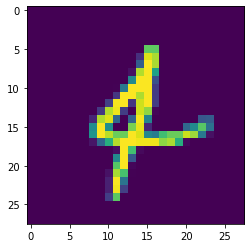

In [ ]:
# Testing the model 
test_index = 300
test_data = tf.reshape(X_test[test_index], (1, size_input))
output = mlpc.forward(test_data)
pred = np.argmax(output, axis=1)
print("Predicted output:= ", int(pred))
print("Actual ouput:= ", test_labels[test_index])
plt.imshow(test_images[test_index])

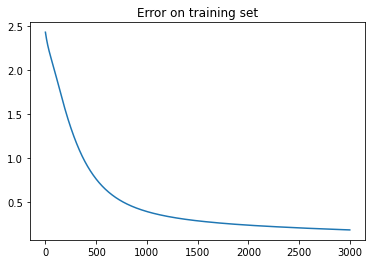

In [ ]:
# Plotting Crossentropy error
plt.title("Error on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], error)

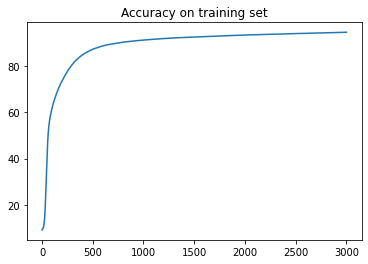

In [ ]:
# Plotting accuracy
plt.title("Accuracy on training set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy)

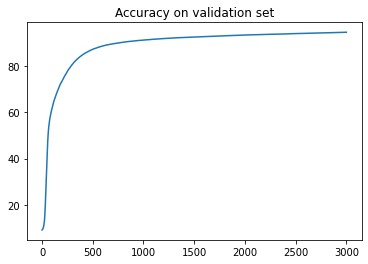

In [ ]:
# Plotting validation accuracy
plt.title("Accuracy on validation set")
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy_val)